In [87]:
from read_data import *
from levelfilter import *
from models import *

In [88]:
import yaml
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [89]:
LEVEL_WAVELET = 6

In [90]:
DATA_PATH = '../data/ppg.csv'

In [91]:
## compare two return X and y 
def take_data_for_two( df, unique_patients = [7,17], experiment_params={}):

    total = []
    valid = []
    ids = []


    X = []
    y = []

    for unique_patient in unique_patients:
        ###experiment_params['select']
        print(experiment_params['select'])
        #df = select_duplicates(df, select= experiment_params['select'])
        temp_df = df[df["PATIENT_CODE"] == unique_patient]
        ##drop here in date column
        
        temp_df.reset_index(drop=True,inplace=True)

        # Calculate the difference between consecutive dates
        diff = temp_df['DATE'].diff()

        # Find continuous dates
        ##if is in the same second doesnt is continuous duplicate##
        continuous_dates = (diff.dt.total_seconds().fillna(0) <= 1)
        ##print(continuous_dates)
        # Split DataFrame into subdataframes with continuous dates
        subdataframes = []
        for i, continuous in enumerate(continuous_dates):
            if i == 0 or not continuous:
                subdataframes.append(temp_df.iloc[i:i+1])
            else:
                subdataframes[-1] = pd.concat([subdataframes[-1], temp_df.iloc[i:i+1]])
        #print(unique_patient)
        #print(len(subdataframes))
        j=0
        total_timeseries = 0

        for i, subdf in enumerate(subdataframes):
            if subdf.shape[0] >= 10:                        # Keeping only timeseries of at least 10" of duration
                subdf.reset_index(drop=True,inplace=True)

                ppg_values = subdf["PPG_ARRAY"].values
                date_values = subdf["DATE"].values
                #print('subdf', subdf)
                # duration = len(date_values)
                # print("Duration in seconds: ", duration)

                time_series = []
                for seconds_values in ppg_values:
                    split_data = seconds_values[1:-1].split(', ')
                    integer_list = [int(item) for item in split_data]

                    for value in integer_list:
                        time_series.append(value)
                ##print(np.power(time_series,2))
                ### change level of wavelet
                features = extract_features(time_series, LEVEL_WAVELET, experiment_params['features'], experiment_params['filter'])

                if subdf["PATIENT_CODE"].values[0] == 7:
                    label = 0
                else:
                    label = 1
                #print("features")
                #print(features)
                X.append(features)
                y.append(label) 

                j+=1
            total_timeseries+=1
            
        ids.append(temp_df["PATIENT_CODE"].values[0])
        total.append(total_timeseries)
        valid.append(j)
        ##print(total_timeseries)
    X = np.array(X)  # Transforming the list of feautures --> numpy arrays
    y = np.array(y)  # Transforming the list of labels--> numpy arrays
    return X, y 


In [92]:
def run_models_for_pairs(unique_patients = [7, 17], config= config ):
    all_results = []
    X_y_data = []   #for save all X y for each experiment
    experiment_time = []

    for experiment in config['experiments']:
        
        print(f"Running {experiment['name']}...")
        df = read_data(path= DATA_PATH, selection= experiment['select'] )
        #unique_patients = [7, 17] 
        X, y = take_data_for_two(df, unique_patients, experiment_params=experiment)
        X_y_data.append({'X': X, 'y': y})  #save X y (features labels)

        #start_time = time.time()
        results_df, confusion_fig, kfold_fig = find_best_model(X, y)
        #end_time = time.time()
        #execution_time = end_time - start_time
        
        #experiment_time.append(execution_time)
        results_df['experiment'] = experiment['name']   #add the name of the project
        #print(results_df.to_string())
        all_results.append(results_df)

    final_results_df = pd.concat(all_results) 
    print(final_results_df.to_string())
    return final_results_df, X_y_data, experiment_time, confusion_fig, kfold_fig

Running experiment_wavelet_none_for_reduction...
Nuber of unique patients: 27
Unique years of birth: [1942 1946 1947 1955 1944 1945 1940 1951 1970 2017 1956 1939 1954 1952
 1937 1948 1943 1957]
Amount of duplicate values: 
 False    74082
True      8481
Name: count, dtype: int64

len of duplicates which removed: 
 4756
Amount of duplicate values after droping: 
 False    77807
Name: count, dtype: int64
last
last


/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

                                 Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score                             experiment
Ridge Classifier                 0.819230   0.820191              0.775359     0.854737  0.793390  experiment_wavelet_none_for_reduction
MLP Classifier                   0.816877   0.811738              0.780554     0.846316  0.791070  experiment_wavelet_none_for_reduction
Linear SVC                       0.811043   0.806886              0.772659     0.842105  0.785955  experiment_wavelet_none_for_reduction
NuSVC                            0.808731   0.811893              0.751846     0.854737  0.775866  experiment_wavelet_none_for_reduction
Linear Discriminant Analysis     0.795934   0.785768              0.751846     0.831579  0.767460  experiment_wavelet_none_for_reduction
Logistic Regression              0.795906   0.793843              0.749282     0.833684  0.766099  experiment_wavelet_none_for_reduction
SVC                              0.793615

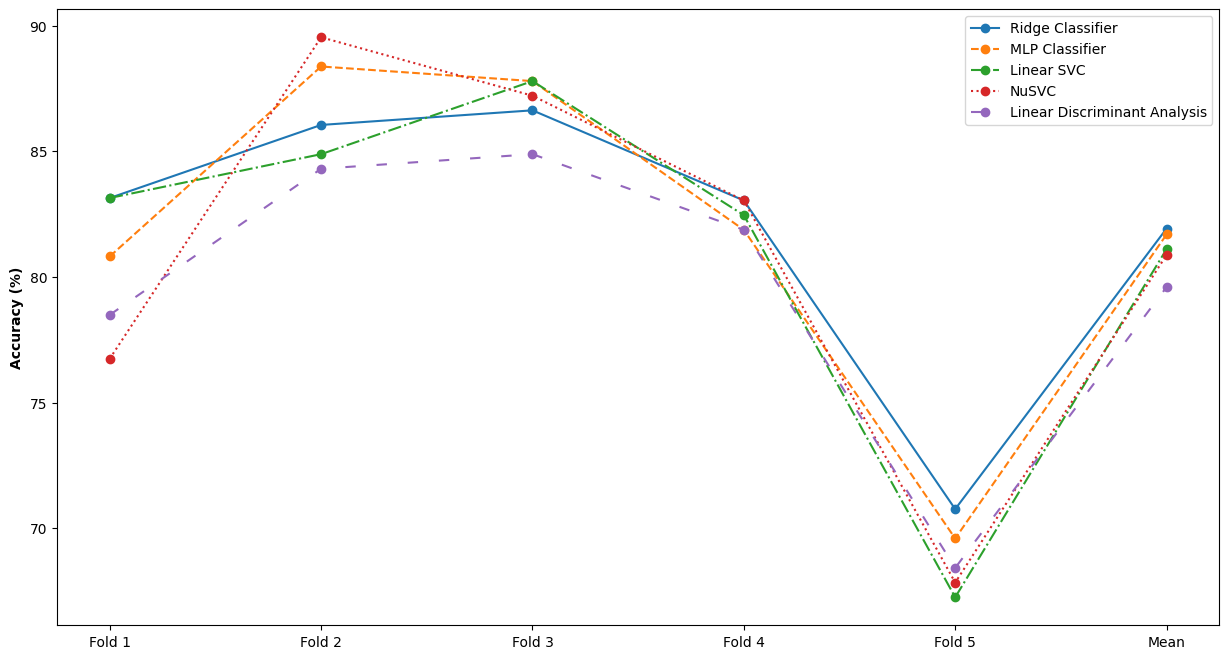

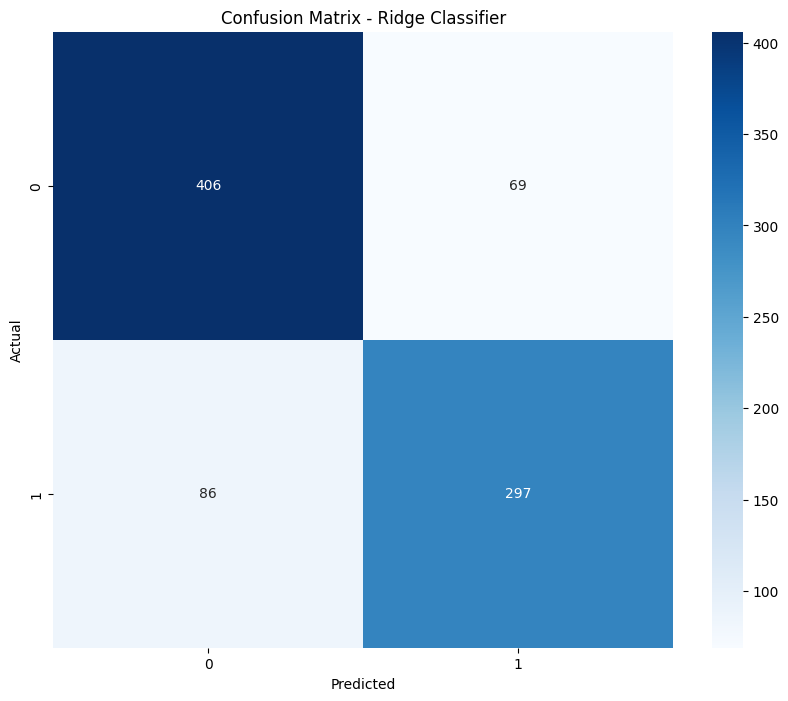

In [93]:
final_results_df, X_y_data, time_before, confusion_fig, kfold_fig = run_models_for_pairs(unique_patients = [7, 17], config= config )

In [94]:
import os
import shutil
if not os.path.exists('experiments'):
    os.makedirs('experiments')

def get_next_experiment_number():
    existing_experiments = [d for d in os.listdir('experiments') if os.path.isdir(os.path.join('experiments', d))]
    if not existing_experiments:
        return 1


/tmp/ipykernel_301604/677510838.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Accuracy', y=final_results_df.index, hue='experiment', data=final_results_df, ci=None)


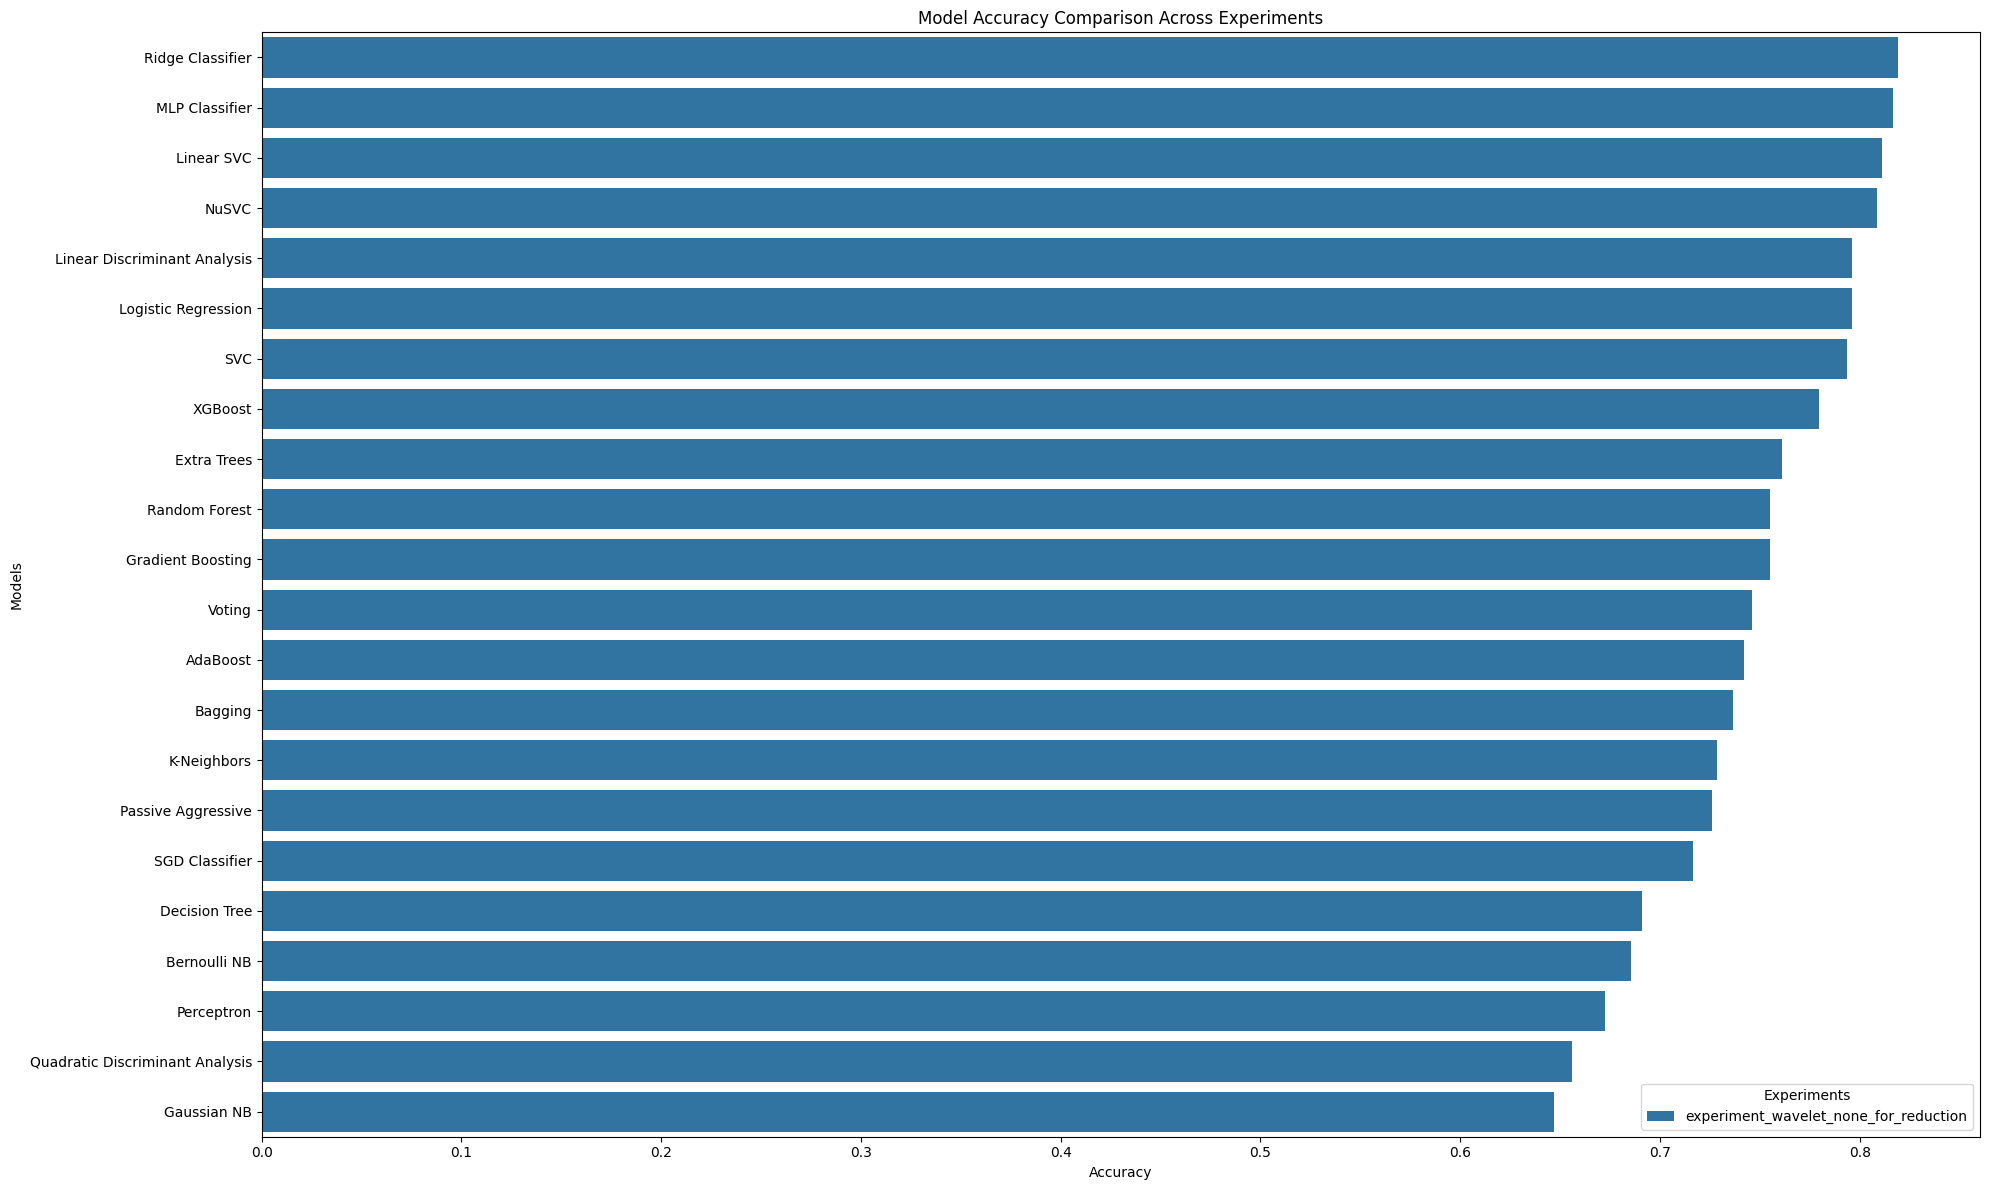

'experiments/experiment_None/config.yaml'

In [95]:
experiment_number = get_next_experiment_number()
experiment_folder = f'experiments/experiment_{experiment_number}'
    
os.makedirs(experiment_folder, exist_ok=True)

results_csv_path = os.path.join(experiment_folder, 'results.csv')
final_results_df.to_csv(results_csv_path, index=True)

#results_df = results_df.sort_values(by='Accuracy', ascending=False)
  
plt.figure(figsize=(20, 12))
sns.barplot(x='Accuracy', y=final_results_df.index, hue='experiment', data=final_results_df, ci=None)
plt.title('Model Accuracy Comparison Across Experiments')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.legend(title='Experiments')
plt.tight_layout()
image_path = os.path.join(experiment_folder, 'model_accuracy_comparison.png')
plt.savefig(image_path)
plt.show()
plt.close()
confusion_fig_path = os.path.join(experiment_folder, 'confusion_matrix.png')
confusion_fig.savefig(confusion_fig_path)
plt.close(confusion_fig)  

kfold_fig_path = os.path.join(experiment_folder, 'kfold_plot.png')
kfold_fig.savefig(kfold_fig_path)
plt.close(kfold_fig)  

    

config_file_path = 'config.yaml'
shutil.copy(config_file_path, os.path.join(experiment_folder, 'config.yaml'))